# 2D Face Data Extraction

## Overview

This notebook demonstrates extracting **detailed face data** from 2D mesh cells. Face data represents flow and velocity at cell boundaries (faces) rather than cell centers.

**Why Face Data Matters**:
- **Cell Centers**: Average conditions within a cell
- **Cell Faces**: Flow across cell boundaries (more accurate for flux calculations)
- **Mass Balance**: Face flows used to verify conservation of mass
- **Flux Analysis**: Pollutant transport, sediment transport require face data

### HDF5 Structure for Face Data

```
/Geometry/2D Flow Areas/
├── {Area Name}/
│   ├── Cells Center Coordinate        # Cell center coords
│   ├── Cells Face and Orientation Info # Face connectivity
│   └── Faces/
│       ├── Coordinate                  # Face center coords
│       ├── Normal Velocity             # Velocity perpendicular to face
│       └── Shear Stress                # Shear at face

/Results/Unsteady/Output/
├── Output Blocks/
│   └── Base Output/
│       └── Unsteady Time Series/
│           └── 2D Flow Areas/
│               └── {Area Name}/
│                   ├── Face Velocity/          # Velocity at each face
│                   ├── Face Shear Stress/
│                   └── Face Flow/              # Flow across face
```

**Face Data Complexity**:
- Structured mesh: 4 faces per cell (N, S, E, W)
- Unstructured mesh: Variable faces per cell (3-8 typical)
- Boundary faces: Special handling at mesh edges

### Reference Documentation

- [HEC-RAS 2D Modeling User's Manual, Chapter 4: Mesh Generation](https://www.hec.usace.army.mil/software/hec-ras/documentation.aspx)
- [HEC-RAS HDF5 Structure Documentation](https://www.hec.usace.army.mil/software/hec-ras/documentation.aspx) - Geometry datasets
- [Finite Volume Method](https://en.wikipedia.org/wiki/Finite_volume_method) - Theory behind face-based computations

### Common Use Cases

- **Mass Balance Verification**: Ensure inflow = outflow + storage
- **Flux Calculations**: Sediment or pollutant transport
- **Velocity Profiles**: Detailed flow patterns near structures
- **Mesh Quality**: Diagnose numerical issues from face data

##### Optional Code Cell For Development/Testing Mode (Local Copy)
##### Uncomment and run this cell instead of the pip cell above


# For Development Mode, add the parent directory to the Python path
import os
import sys
from pathlib import Path

current_file = Path(os.getcwd()).resolve()
rascmdr_directory = current_file.parent

# Use insert(0) instead of append() to give highest priority to local version
if str(rascmdr_directory) not in sys.path:
    sys.path.insert(0, str(rascmdr_directory))

print("Loading ras-commander from local dev copy")
from ras_commander import *


# HEC-RAS 2D Detail Face Data Extraction Examples

This notebook demonstrates how to extract detailed 2D face data, display individual cell face results and calculate a discharge weighted velocity using a user-provided profile line located where cell faces are perpendicular to flow. 


## Package Installation and Environment Setup
Uncomment and run package installation commands if needed

In [1]:
# Install ras-commander from pip (uncomment to install if needed)
#!pip install ras-commander
# This installs ras-commander and all dependencies

In [2]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
USE_LOCAL_SOURCE = True  # <-- TOGGLE THIS

if USE_LOCAL_SOURCE:
    import sys
    from pathlib import Path
    local_path = str(Path.cwd().parent)
    if local_path not in sys.path:
        sys.path.insert(0, local_path)
    print(f"📁 LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    print("📦 PIP PACKAGE MODE: Loading installed ras-commander")

# Import ras-commander
from ras_commander import HdfBase, HdfMesh, HdfPlan, HdfResultsMesh, HdfResultsPlan, HdfUtils, RasCmdr, RasExamples, get_logger, init_ras_project, ras

# Additional imports for this notebook
import h5py
import numpy as np
import pandas as pd
import requests
from tqdm import tqdm
import scipy
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython import display
import psutil  # For getting system CPU info
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import subprocess
import os
import shutil
from datetime import datetime, timedelta
from pathlib import Path  # Ensure pathlib is imported for file operations
import pyproj
from shapely.geometry import Point, LineString, Polygon
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
import logging
import rasterio
from rasterio.plot import show

# Verify which version loaded
import ras_commander
print(f"✓ Loaded: {ras_commander.__file__}")

📦 PIP PACKAGE MODE: Loading installed ras-commander
✓ Loaded: c:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\ras_commander\__init__.py


## Parameters

Configure these values to customize the notebook for your project.

In [3]:
# =============================================================================
# PARAMETERS - Edit these to customize the notebook
# =============================================================================
from pathlib import Path

# Project Configuration
PROJECT_NAME = "Chippewa_2D"           # Example project to extract
RAS_VERSION = "6.6"               # HEC-RAS version (6.3, 6.5, 6.6, etc.)

# HDF Analysis Settings
PLAN = "02"                       # Plan number (for HDF file path)
TIME_INDEX = -1                   # Time step index (-1 = last)
PROFILE = "Max"                   # Profile name for steady analysis

Note: This notebook relies on the Chippewa 2D Project along with:
 - A user-generated GeoJSON containing the proposed profile lines
 - An example is provided in the "data" subfolder with name profile_lines_chippewa2D.geojson

In [4]:
# Extract the Chippewa_2D example project using static method
chippewa_path = RasExamples.extract_project(PROJECT_NAME, suffix="13")
print(f"Extracted project to: {chippewa_path}")

# Verify the path exists
print(f"Chippewa_2D project exists: {chippewa_path.exists()}")

# Initialize the RAS project using the default global ras object
init_ras_project(chippewa_path, RAS_VERSION)
from ras_commander import get_logger  # Import after sys.path is set if not installed
logger = get_logger(__name__)
logger.info(f"Chippewa_2D project initialized with folder: {ras.project_folder}")

# Define the plan number to execute
plan_number = PLAN

# Execute Plan 02 using RasCmdr with skip_existing=True
RasCmdr.compute_plan(
    plan_number,
    ras_object=ras,
    skip_existing=True,
    num_cores=2
)

2025-12-29 00:14:43 - ras_commander.RasExamples - INFO - Found zip file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\Example_Projects_6_6.zip
2025-12-29 00:14:43 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2025-12-29 00:14:43 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2025-12-29 00:14:43 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2025-12-29 00:14:43 - ras_commander.RasExamples - INFO - Extracting project 'Chippewa_2D' as 'Chippewa_2D_13'
2025-12-29 00:14:43 - ras_commander.RasExamples - INFO - Folder 'Chippewa_2D_13' already exists. Deleting existing folder...
2025-12-29 00:14:43 - ras_commander.RasExamples - INFO - Existing folder 'Chippewa_2D_13' has been deleted.
2025-12-29 00:14:43 - ras_commander.RasExamples - INFO - Successfully extracted project 'Chippewa_2D' to C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippew

Extracted project to: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13
Chippewa_2D project exists: True


2025-12-29 00:16:24 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 02
2025-12-29 00:16:24 - ras_commander.RasCmdr - INFO - Total run time for plan 02: 100.46 seconds


True

In [5]:
# Show ras object info
ras.plan_df

,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,DSS File,Friction Slope Method,UNET D2 SolverType,UNET D2 Name,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path
0,02,04,01,100ft Sediment,6.40,100ft Sediment,"02apr2019,0000,05may2019,2400",2MIN,30MIN,-1,...,dss,1,PARDISO (Direct),Perimeter 1,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,04,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...


In [6]:
ras.unsteady_df

,unsteady_number,full_path,Flow Title,Program Version,Use Restart,Precipitation Mode,Wind Mode,Met BC=Precipitation|Expanded View,Met BC=Precipitation|Gridded Source
0,04,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,2019-test,6.40,0,Disable,No Wind Forces,0,DSS


In [7]:
ras.boundaries_df 

,unsteady_number,boundary_condition_number,river_reach_name,river_station,storage_area_name,pump_station_name,bc_type,hydrograph_type,Interval,DSS Path,...,hydrograph_values,DSS File,full_path,Flow Title,Program Version,Use Restart,Precipitation Mode,Wind Mode,Met BC=Precipitation|Expanded View,Met BC=Precipitation|Gridded Source
0,04,1,,,,,Flow Hydrograph,Flow Hydrograph,1DAY,,...,"[5770, 5760, 6200, 5630, 6400, 6970, 6610, 610...",NaN,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,2019-test,6.40,0,Disable,No Wind Forces,0,DSS
1,04,2,,,,,Flow Hydrograph,Flow Hydrograph,1DAY,/MISSISSIPPI R LAKE PEPIN/765.51/FLOW/01JAN197...,...,"[11800, 12300, 12400, 12200, 12400, 11900, 117...",..\..\2018\ChippewaRiverBedload\RAS_Final\Sedi...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,2019-test,6.40,0,Disable,No Wind Forces,0,DSS
2,04,3,,,,,Stage Hydrograph,Stage Hydrograph,1DAY,/MISSISSIPPI R LOWER POOL 4/754.00/STAGE/01JAN...,...,"[666.68, 666.81, 666.82, 666.8, 666.83, 666.87...",..\..\2018\ChippewaRiverBedload\RAS_Final\Sedi...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,2019-test,6.40,0,Disable,No Wind Forces,0,DSS
3,04,4,,,,,Flow Hydrograph,Flow Hydrograph,1DAY,,...,"[18093.43, 20945.317590.3917795.6817894.251879...",NaN,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,2019-test,6.40,0,Disable,No Wind Forces,0,DSS
4,04,5,,,,,Stage Hydrograph,Stage Hydrograph,1DAY,,...,"[679.743, 680.239, 679.775, 679.757, 679.75, 6...",NaN,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,2019-test,6.40,0,Disable,No Wind Forces,0,DSS


In [8]:
ras.get_hdf_entries()

,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,DSS File,Friction Slope Method,UNET D2 SolverType,UNET D2 Name,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path
0,02,04,01,100ft Sediment,6.40,100ft Sediment,"02apr2019,0000,05may2019,2400",2MIN,30MIN,-1,...,dss,1,PARDISO (Direct),Perimeter 1,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,04,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...


# Find Paths for Results and Geometry HDF's

In [9]:
# Define the HDF input path as Plan Number

plan_number = PLAN  # Assuming we're using plan 01 as in the previous code


In [10]:
ras.plan_df

,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,DSS File,Friction Slope Method,UNET D2 SolverType,UNET D2 Name,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path
0,02,04,01,100ft Sediment,6.40,100ft Sediment,"02apr2019,0000,05may2019,2400",2MIN,30MIN,-1,...,dss,1,PARDISO (Direct),Perimeter 1,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,04,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...


In [11]:
PLAN

'02'

In [12]:
# Get the plan HDF path for the plan_number defined above
plan_hdf_path = ras.plan_df.loc[ras.plan_df['plan_number'] == plan_number, 'HDF_Results_Path'].values[0]

In [13]:
plan_hdf_path

'C:\\Users\\billk_clb\\anaconda3\\envs\\rascmdr_piptest\\Lib\\site-packages\\examples\\example_projects\\Chippewa_2D_13\\Chippewa_2D.p02.hdf'

In [14]:
# Alternate: Get the geometry HDF path if you are extracting geometry elements from the geometry HDF 
geom_hdf_path = ras.plan_df.loc[ras.plan_df['plan_number'] == plan_number, 'Geom Path'].values[0] + '.hdf'

In [15]:
geom_hdf_path

'C:\\Users\\billk_clb\\anaconda3\\envs\\rascmdr_piptest\\Lib\\site-packages\\examples\\example_projects\\Chippewa_2D_13\\Chippewa_2D.g01.hdf'

In [16]:
# Example: Extract runtime and compute time data
print("\nExample 2: Extracting runtime and compute time data")
runtime_df = HdfResultsPlan.get_runtime_data(hdf_path=plan_number)
if runtime_df is not None:
    runtime_df
else:
    print("No runtime data found.")

2025-12-29 00:16:24 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.p02.hdf
2025-12-29 00:16:24 - ras_commander.hdf.HdfResultsPlan - INFO - Extracting Plan Information from: Chippewa_2D.p02.hdf
2025-12-29 00:16:24 - ras_commander.hdf.HdfResultsPlan - INFO - Plan Name: 100ft Sediment
2025-12-29 00:16:24 - ras_commander.hdf.HdfResultsPlan - INFO - Simulation Duration (hours): 816.0



Example 2: Extracting runtime and compute time data


In [17]:
# For all of the RasGeomHdf Class Functions, we will use geom_hdf_path
print(geom_hdf_path)

# For the example project, plan 02 is associated with geometry 09
# If you want to call the geometry by number, call RasHdfGeom functions with a number
# Otherwise, if you want to look up geometry hdf path by plan number, follow the logic in the previous code cells

C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


In [18]:
# Use HdfUtils for extracting projection
print("\nExtracting Projection from HDF")
projection = HdfBase.get_projection(hdf_path=geom_hdf_path)
if projection:
    print(f"Projection: {projection}")
else:
    print("No projection information found.")

2025-12-29 00:16:24 - ras_commander.hdf.HdfBase - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2025-12-29 00:16:24 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2025-12-29 00:16:24 - ras_commander.hdf.HdfBase - CRITICAL - No valid projection found. Checked:
1. HDF file projection attribute: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2. RASMapper projection file C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\.Winona_Upload\LifeSim model\Winona Levee SQRA 2019\RAS\AW\MMC_Projection.prj found in RASMapper file, but was invalid
To fix this:
1. Open RASMapper
2. Click Map 


Extracting Projection from HDF
No projection information found.


In [19]:
# Set the  to USA Contiguous Albers Equal Area Conic (USGS version)
# Note, we would usually call the projection function in HdfMesh but the projection is not set in this example project
projection = 'EPSG:5070'  

In [20]:
# Use HdfPlan for geometry-related operations
print("\nExample: Extracting Base Geometry Attributes")
geom_attrs = HdfPlan.get_geometry_information(geom_hdf_path)

if not geom_attrs.empty:
    # Display the DataFrame directly
    print("Base Geometry Attributes:")
    geom_attrs
else:
    print("No base geometry attributes found.")


2025-12-29 00:16:24 - ras_commander.hdf.HdfPlan - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2025-12-29 00:16:24 - ras_commander.hdf.HdfPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2025-12-29 00:16:24 - ras_commander.hdf.HdfPlan - INFO - Getting geometry attributes from C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2025-12-29 00:16:24 - ras_commander.hdf.HdfPlan - INFO - Checking for Geometry group in C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2025-12-29 00:16:24 - ras_commander.hdf.HdfPlan - INFO - Getting root level geometry attributes
2025-12-29 00:16:24 - ras_com


Example: Extracting Base Geometry Attributes
Base Geometry Attributes:


In [21]:
# Use HdfMesh for geometry-related operations
print("\nExample 3: Listing 2D Flow Area Names")
flow_area_names = HdfMesh.get_mesh_area_names(geom_hdf_path)
print("2D Flow Area Names:", flow_area_names)

2025-12-29 00:16:24 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2025-12-29 00:16:24 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf



Example 3: Listing 2D Flow Area Names
2D Flow Area Names: ['Perimeter 1']


In [22]:
# Example: Get 2D Flow Area Attributes (get_geom_2d_flow_area_attrs)
print("\nExample: Extracting 2D Flow Area Attributes")
flow_area_attributes = HdfMesh.get_mesh_area_attributes(geom_hdf_path)
flow_area_attributes


2025-12-29 00:16:24 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2025-12-29 00:16:24 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf



Example: Extracting 2D Flow Area Attributes


,Value
Name,b'Perimeter 1'
Locked,0
Mann,0.06
Multiple Face Mann n,1
Composite LC,1
Cell Vol Tol,0.01
Cell Min Area Fraction,0.01
Face Profile Tol,0.01
Face Area Tol,0.01
Face Conv Ratio,0.02


In [23]:
# Example: Get 2D Flow Area Perimeter Polygons (mesh_areas)
print("\nExample: Extracting 2D Flow Area Perimeter Polygons")
mesh_areas = HdfMesh.get_mesh_areas(geom_hdf_path)  # Corrected function name

2025-12-29 00:16:24 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2025-12-29 00:16:24 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2025-12-29 00:16:24 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2025-12-29 00:16:24 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2025-12-29 00:16:24 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\e


Example: Extracting 2D Flow Area Perimeter Polygons


In [24]:
# Example: Extract mesh cell faces
print("\nExample: Extracting mesh cell faces")

# Get mesh cell faces using the standardize_input decorator for consistent file handling
mesh_cell_faces = HdfMesh.get_mesh_cell_faces(geom_hdf_path)

# Display the first few rows of the mesh cell faces GeoDataFrame
print("First few rows of mesh cell faces:")
mesh_cell_faces.head()

2025-12-29 00:16:24 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2025-12-29 00:16:24 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2025-12-29 00:16:24 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2025-12-29 00:16:24 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2025-12-29 00:16:24 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\e


Example: Extracting mesh cell faces
First few rows of mesh cell faces:


,mesh_name,face_id,geometry
0,Perimeter 1,0,"LINESTRING (1027231.594 7857846.138, 1026833.9..."
1,Perimeter 1,1,"LINESTRING (1026833.966 7857797.923, 1026849.8..."
2,Perimeter 1,2,"LINESTRING (1026849.886 7857613.488, 1027249.0..."
3,Perimeter 1,3,"LINESTRING (1027249.03 7857618.591, 1027231.59..."
4,Perimeter 1,4,"LINESTRING (1027231.594 7857846.138, 1027231.5..."


In [25]:
# Set the projection to USA Contiguous Albers Equal Area Conic (USGS version)
# Note, we would usually call the projection function in HdfMesh but the projection is not set in this example project
projection = 'EPSG:5070'  # NAD83 / Conus Albers


Example: Finding the nearest cell face to a given point
Nearest cell face to point (1025677, 7853731):
Face ID: 209
Distance: 5.74 units


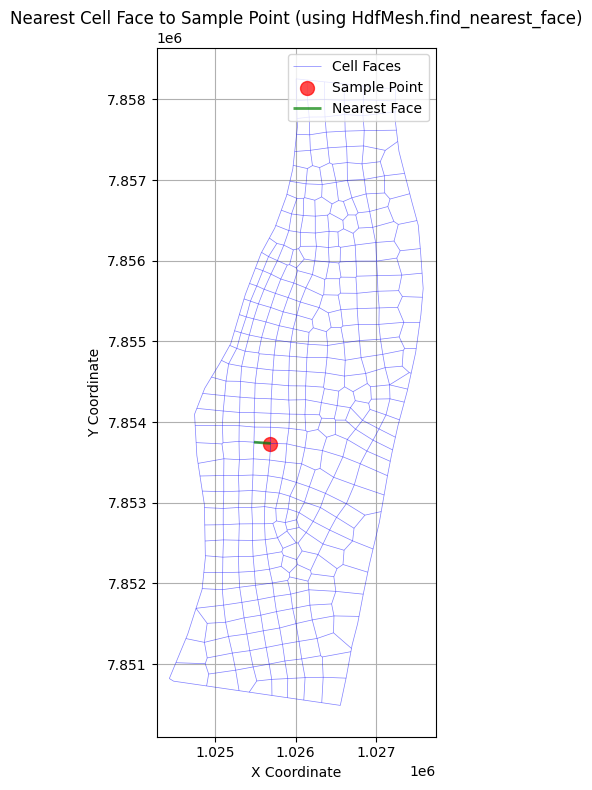

In [26]:
# Example: Find the nearest cell face to a given point using library API
# The HdfMesh.find_nearest_face() function replaces the notebook's custom helper

print("\nExample: Finding the nearest cell face to a given point")

from shapely.geometry import Point
import geopandas as gpd

# Create a sample point (coordinates in project CRS)
sample_coords = (1025677, 7853731)

# Use library API to find nearest face
# HdfMesh.find_nearest_face(point, cell_faces_gdf, mesh_name=None) -> (face_id, distance)
nearest_face_id, distance = HdfMesh.find_nearest_face(sample_coords, mesh_cell_faces)

print(f"Nearest cell face to point {sample_coords}:")
print(f"Face ID: {nearest_face_id}")
print(f"Distance: {distance:.2f} units")

# Visualize the result
if nearest_face_id is not None:
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot all cell faces
    mesh_cell_faces.plot(ax=ax, color='blue', linewidth=0.5, alpha=0.5, label='Cell Faces')

    # Plot the sample point
    sample_point_gdf = gpd.GeoDataFrame(
        {'geometry': [Point(sample_coords)]},
        crs=mesh_cell_faces.crs
    )
    sample_point_gdf.plot(ax=ax, color='red', markersize=100, alpha=0.7, label='Sample Point')

    # Plot the nearest cell face
    nearest_face = mesh_cell_faces[mesh_cell_faces['face_id'] == nearest_face_id]
    nearest_face.plot(ax=ax, color='green', linewidth=2, alpha=0.7, label='Nearest Face')

    # Set labels and title
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('Nearest Cell Face to Sample Point (using HdfMesh.find_nearest_face)')

    # Add legend and grid
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("Unable to find nearest face - check mesh_cell_faces data")


2025-12-29 00:16:24 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2025-12-29 00:16:24 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2025-12-29 00:16:24 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2025-12-29 00:16:24 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2025-12-29 00:16:24 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\e


Example: Extracting mesh cell faces and plotting with profile lines
First few rows of mesh cell faces:


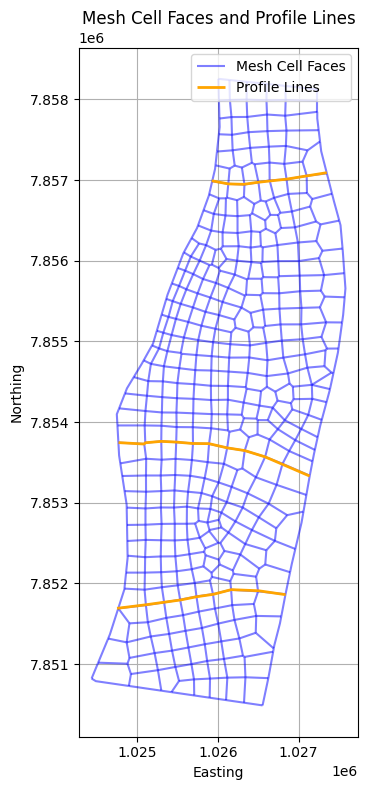

In [27]:
# Example: Extract mesh cell faces and plot with profile lines
print("\nExample: Extracting mesh cell faces and plotting with profile lines")

# Get mesh cell faces
mesh_cell_faces = HdfMesh.get_mesh_cell_faces(geom_hdf_path)

# Display the first few rows of the mesh cell faces DataFrame
print("First few rows of mesh cell faces:")
mesh_cell_faces

# Load the GeoJSON file for profile lines
geojson_path = Path(r'data/profile_lines_chippewa2D.geojson')  # Update with the correct path
profile_lines_gdf = gpd.read_file(geojson_path)

# Set the Coordinate Reference System (CRS) to EPSG:5070
profile_lines_gdf = profile_lines_gdf.set_crs(epsg=5070, allow_override=True)

# Plot the mesh cell faces and profile lines together
fig, ax = plt.subplots(figsize=(12, 8))
mesh_cell_faces.plot(ax=ax, color='blue', alpha=0.5, edgecolor='k', label='Mesh Cell Faces')
profile_lines_gdf.plot(ax=ax, color='orange', linewidth=2, label='Profile Lines')

# Set labels and title
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
ax.set_title('Mesh Cell Faces and Profile Lines')

# Add grid and legend
ax.grid(True)
ax.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

2025-12-29 00:16:25 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2025-12-29 00:16:25 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2025-12-29 00:16:25 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2025-12-29 00:16:25 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2025-12-29 00:16:25 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\e


Example: Extracting mesh cell faces near profile lines
Loaded 814 mesh cell faces
Loaded 3 profile lines


2025-12-29 00:16:25 - ras_commander.hdf.HdfMesh - INFO - Found 16 faces along profile line


Profile Line 1: Found 16 perpendicular faces


2025-12-29 00:16:26 - ras_commander.hdf.HdfMesh - INFO - Found 25 faces along profile line


Profile Line 2: Found 25 perpendicular faces


2025-12-29 00:16:27 - ras_commander.hdf.HdfMesh - INFO - Found 19 faces along profile line


Profile Line 3: Found 19 perpendicular faces

Total profile lines processed: 3


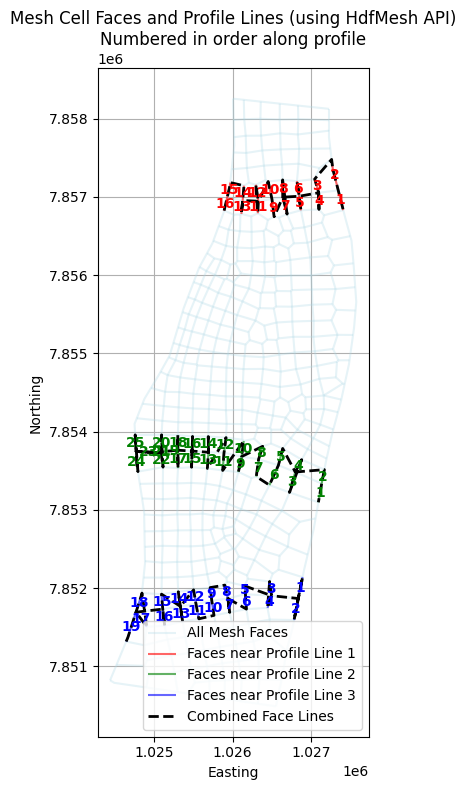


Faces near profile lines:
  Profile Line 1: 16 faces
    Distance range: 0.0 to 1436.8
  Profile Line 2: 25 faces
    Distance range: 0.0 to 2448.1
  Profile Line 3: 19 faces
    Distance range: 0.0 to 2114.2


In [28]:
# Example: Extracting mesh cell faces near profile lines using library API
# HdfMesh.get_faces_along_profile_line() replaces ~100 lines of custom helper functions

print("\nExample: Extracting mesh cell faces near profile lines")

# Get mesh cell faces using HdfMesh class
mesh_cell_faces = HdfMesh.get_mesh_cell_faces(geom_hdf_path)
print(f"Loaded {len(mesh_cell_faces)} mesh cell faces")

# Load the GeoJSON file for profile lines
geojson_path = Path(r'data/profile_lines_chippewa2D.geojson')
profile_lines_gdf = gpd.read_file(geojson_path)
profile_lines_gdf = profile_lines_gdf.set_crs(epsg=5070, allow_override=True)
print(f"Loaded {len(profile_lines_gdf)} profile lines")

# Initialize dictionary to store faces near each profile line
faces_near_profile_lines = {}

# Define thresholds
distance_threshold = 10  # Maximum distance from profile line (units depend on CRS)
angle_threshold = 60     # Maximum angle deviation from perpendicular (degrees)

# Use library API to find faces along each profile line
# This replaces the custom calculate_angle, break_line_into_segments,
# angle_difference, order_faces_along_profile functions
for idx, row in profile_lines_gdf.iterrows():
    profile_name = row.get('Name', f'Profile_{idx}')
    profile_line = row.geometry

    # Library call - handles segment breaking, angle calculation, distance filtering, ordering
    profile_faces = HdfMesh.get_faces_along_profile_line(
        profile_line=profile_line,
        cell_faces_gdf=mesh_cell_faces,
        distance_threshold=distance_threshold,
        angle_threshold=angle_threshold,
        order_by_distance=True  # Returns faces ordered along profile
    )

    faces_near_profile_lines[profile_name] = profile_faces
    print(f"{profile_name}: Found {len(profile_faces)} perpendicular faces")

print(f"\nTotal profile lines processed: {len(faces_near_profile_lines)}")

# Optional: Combine selected faces into continuous linestrings
profile_to_faceline = gpd.GeoDataFrame(columns=['profile_name', 'geometry'], crs=profile_lines_gdf.crs)

for profile_name, faces in faces_near_profile_lines.items():
    if not faces.empty:
        # Use library function to combine faces into linestring
        combined_line = HdfMesh.combine_faces_to_linestring(
            faces,
            order_column='distance_along_profile'
        )
        if combined_line is not None:
            new_row = gpd.GeoDataFrame({
                'profile_name': [profile_name],
                'geometry': [combined_line]
            }, crs=profile_lines_gdf.crs)
            profile_to_faceline = pd.concat([profile_to_faceline, new_row], ignore_index=True)

# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))

# Plot all mesh cell faces in light blue
mesh_cell_faces.plot(ax=ax, color='lightblue', alpha=0.3, edgecolor='k', label='All Mesh Faces')

# Plot selected faces for each profile line with numbers
colors = ['red', 'green', 'blue', 'orange', 'purple']
for (profile_name, faces), color in zip(faces_near_profile_lines.items(), colors):
    if not faces.empty:
        faces.plot(ax=ax, color=color, alpha=0.6, label=f'Faces near {profile_name}')

        # Add numbers to faces (using distance_along_profile for ordering)
        for i, (idx, face) in enumerate(faces.iterrows()):
            midpoint = face.geometry.interpolate(0.5, normalized=True)
            ax.text(midpoint.x, midpoint.y, str(i+1),
                   color=color, fontweight='bold', ha='center', va='center')

# Plot the combined linestrings
if not profile_to_faceline.empty:
    profile_to_faceline.plot(ax=ax, color='black', linewidth=2,
                            linestyle='--', label='Combined Face Lines')

# Set labels and title
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
ax.set_title('Mesh Cell Faces and Profile Lines (using HdfMesh API)\nNumbered in order along profile')

ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

# Display the results
print("\nFaces near profile lines:")
for name, faces in faces_near_profile_lines.items():
    print(f"  {name}: {len(faces)} faces")
    if not faces.empty and 'distance_along_profile' in faces.columns:
        print(f"    Distance range: {faces['distance_along_profile'].min():.1f} to {faces['distance_along_profile'].max():.1f}")


-----

In [29]:
# Get face property tables with error handling
face_property_tables = HdfMesh.get_mesh_face_property_tables(geom_hdf_path)
face_property_tables

2025-12-29 00:16:27 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2025-12-29 00:16:27 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2025-12-29 00:16:27 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2025-12-29 00:16:27 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


{'Perimeter 1':       Face ID          Z       Area Wetted Perimeter Manning's n
 0           0  683.78314        0.0              0.0  0.06680043
 1           0  683.98315  25.314476        311.06384  0.06680043
 2           0   684.1409   77.88681         355.3648  0.06600185
 3           0   684.1893  98.404495        368.92633  0.06575739
 4           0   684.5791  249.17476         400.5631  0.06531201
 ...       ...        ...        ...              ...         ...
 5183      812  683.02405   1228.017        475.78708  0.06334631
 5184      813   683.6363        0.0              0.0  0.07539803
 5185      813   683.8363  13.135144        199.78789  0.07539803
 5186      813   683.9459  45.552128        391.64612  0.07541533
 5187      813  683.94946   51.69725         397.8351  0.07541589
 
 [5188 rows x 5 columns]}

2025-12-29 00:16:28 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-29 00:16:28 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-29 00:16:28 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-29 00:16:28 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-29 00:16:28 - matplotlib.cat

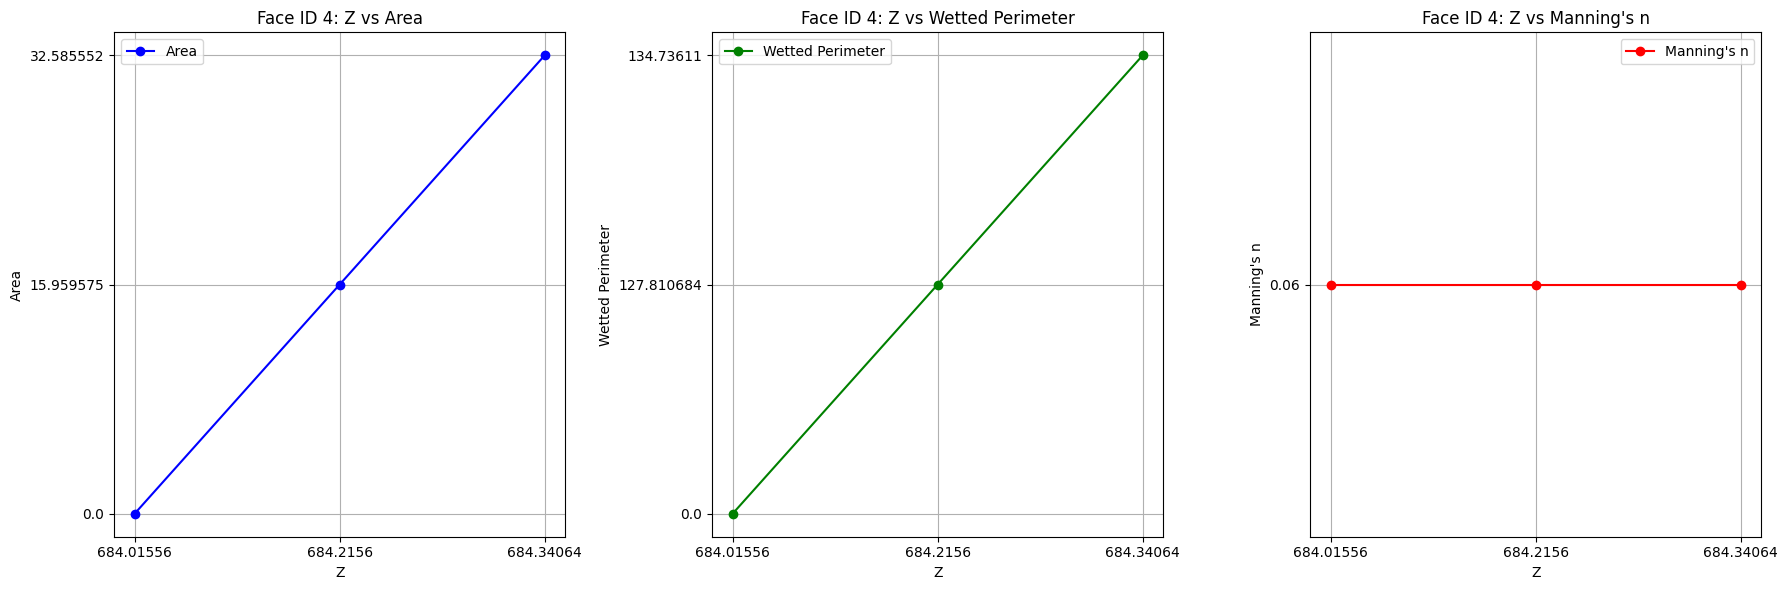

In [30]:
# Extract the face property table for Face ID 4 and display it
import matplotlib.pyplot as plt

face_id = 4
face_properties = face_property_tables['Perimeter 1'][face_property_tables['Perimeter 1']['Face ID'] == face_id]

# Create subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Elevation vs Area
axs[0].plot(face_properties['Elevation'], face_properties['Area'], marker='o', color='blue', label='Area')
axs[0].set_title(f'Face ID {face_id}: Elevation vs Area')
axs[0].set_xlabel('Elevation')
axs[0].set_ylabel('Area')
axs[0].grid(True)
axs[0].legend()

# Plot Elevation vs Wetted Perimeter
axs[1].plot(face_properties['Elevation'], face_properties['Wetted Perimeter'], marker='o', color='green', label='Wetted Perimeter')
axs[1].set_title(f'Face ID {face_id}: Elevation vs Wetted Perimeter')
axs[1].set_xlabel('Elevation')
axs[1].set_ylabel('Wetted Perimeter')
axs[1].grid(True)
axs[1].legend()

# Plot Elevation vs Manning's n
axs[2].plot(face_properties['Elevation'], face_properties["Manning's n"], marker='o', color='red', label="Manning's n")
axs[2].set_title(f"Face ID {face_id}: Elevation vs Manning's n")
axs[2].set_xlabel('Elevation')
axs[2].set_ylabel("Manning's n")
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()

## Cell Property Tables

Similar to face property tables, **cell property tables** provide elevation-volume relationships for each mesh cell.
This data defines how cell volume changes with water surface elevation and is used internally by HEC-RAS for 2D hydraulic computations.

Note: Cell surface area is stored in a separate dataset (`Cells Surface Area`), not in the elevation-volume table.

In [ ]:
# Get cell property tables for all mesh areas
cell_property_tables = HdfMesh.get_mesh_cell_property_tables(geom_hdf_path)

# Display available mesh areas
if cell_property_tables:
    print(f"Mesh areas with cell property tables: {list(cell_property_tables.keys())}")
    
    # Show structure of first mesh area
    for mesh_name, df in cell_property_tables.items():
        print()
        print(f"Mesh: {mesh_name}")
        print(f"  Shape: {df.shape}")
        print(f"  Columns: {list(df.columns)}")
        print(f"  Number of unique cells: {df['Cell ID'].nunique()}")
        break
else:
    print("No cell property tables found in geometry HDF.")
    print("Cell property tables are generated during geometry preprocessing.")

In [ ]:
# Plot elevation-volume curve for a sample cell
if cell_property_tables:
    import matplotlib.pyplot as plt

    mesh_name = list(cell_property_tables.keys())[0]
    df = cell_property_tables[mesh_name]

    # Select a sample cell - use first available cell ID
    sample_cell_id = df['Cell ID'].iloc[0]
    cell_data = df[df['Cell ID'] == sample_cell_id]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(cell_data['Volume'], cell_data['Elevation'], marker='o', linewidth=2, markersize=4)
    ax.set_xlabel('Volume (cubic feet)', fontsize=12)
    ax.set_ylabel('Elevation (feet)', fontsize=12)
    ax.set_title(f'Cell {sample_cell_id} Elevation-Volume Relationship - Mesh: {mesh_name}', fontsize=14)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping plot - no cell property tables available.")

In [31]:
# Get mesh timeseries output
# Get mesh areas from previous code cell
mesh_areas = HdfMesh.get_mesh_area_names(geom_hdf_path)

mesh_name = mesh_areas[0]  # Use the first 2D flow area name
timeseries_da = HdfResultsMesh.get_mesh_timeseries(plan_hdf_path, mesh_name, "Water Surface")



2025-12-29 00:16:28 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2025-12-29 00:16:28 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2025-12-29 00:16:28 - ras_commander.hdf.HdfResultsMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.p02.hdf
2025-12-29 00:16:28 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.p02.hdf


In [32]:
print(f"\nMesh Timeseries Output (Water Surface) for {mesh_name}:")
timeseries_da


Mesh Timeseries Output (Water Surface) for Perimeter 1:


<xarray.DataArray (time: 1633, cell_id: 433)> Size: 3MB
array([[681.284  , 681.25146, 681.22766, ..., 685.05927, 680.1254 ,
        683.6363 ],
       [681.2948 , 681.26215, 681.23834, ..., 685.05927, 680.1254 ,
        683.6363 ],
       [681.30634, 681.2736 , 681.2497 , ..., 685.05927, 680.1254 ,
        683.6363 ],
       ...,
       [680.89825, 680.8681 , 680.8455 , ..., 685.05927, 680.1254 ,
        683.7824 ],
       [680.8906 , 680.8606 , 680.8381 , ..., 685.05927, 680.1254 ,
        683.7824 ],
       [680.8839 , 680.854  , 680.83167, ..., 685.05927, 680.1254 ,
        683.7824 ]], shape=(1633, 433), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 13kB 2019-04-02 ... 2019-05-06
  * cell_id  (cell_id) int64 3kB 0 1 2 3 4 5 6 7 ... 426 427 428 429 430 431 432
Attributes:
    units:      ft
    mesh_name:  Perimeter 1
    variable:   Water Surface

In [33]:
# Get mesh cells timeseries output
cells_timeseries_ds = HdfResultsMesh.get_mesh_cells_timeseries(plan_hdf_path, mesh_name)

2025-12-29 00:16:28 - ras_commander.hdf.HdfResultsMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.p02.hdf
2025-12-29 00:16:28 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.p02.hdf
2025-12-29 00:16:28 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Depth' not found in the HDF file for mesh 'Perimeter 1'. Skipping.
2025-12-29 00:16:28 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Velocity' not found in the HDF file for mesh 'Perimeter 1'. Skipping.
2025-12-29 00:16:28 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Velocity X' not found in the HDF file for mesh 'Perimeter 1'. Skipping.
2025-12-29 00:16:28 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Velocity Y' not found in the H

In [34]:
print("\nMesh Cells Timeseries Output:")
cells_timeseries_ds


Mesh Cells Timeseries Output:


{'Perimeter 1': <xarray.Dataset> Size: 13MB
 Dimensions:        (time: 1633, cell_id: 433, face_id: 814)
 Coordinates:
   * time           (time) datetime64[ns] 13kB 2019-04-02 ... 2019-05-06
   * cell_id        (cell_id) int64 3kB 0 1 2 3 4 5 6 ... 427 428 429 430 431 432
   * face_id        (face_id) int64 7kB 0 1 2 3 4 5 6 ... 808 809 810 811 812 813
 Data variables:
     Water Surface  (time, cell_id) float32 3MB 681.3 681.3 681.2 ... 680.1 683.8
     Face Velocity  (time, face_id) float32 5MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 -0.0
     Face Flow      (time, face_id) float32 5MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
 Attributes:
     mesh_name:   Perimeter 1
     start_time:  2019-04-02 00:00:00}

In [35]:
# Get mesh faces timeseries output
faces_timeseries_ds = HdfResultsMesh.get_mesh_faces_timeseries(plan_hdf_path, mesh_name)

2025-12-29 00:16:28 - ras_commander.hdf.HdfResultsMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.p02.hdf
2025-12-29 00:16:28 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.p02.hdf
2025-12-29 00:16:28 - ras_commander.hdf.HdfResultsMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.p02.hdf
2025-12-29 00:16:28 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.p02.hdf
2025-12-29 00:16:28 - ras_commander.hdf.HdfResultsMesh - INFO - Using existing Path object HDF fi

In [36]:
print("\nMesh Faces Timeseries Output:")
faces_timeseries_ds



Mesh Faces Timeseries Output:


<xarray.Dataset> Size: 11MB
Dimensions:        (time: 1633, face_id: 814)
Coordinates:
  * time           (time) datetime64[ns] 13kB 2019-04-02 ... 2019-05-06
  * face_id        (face_id) int64 7kB 0 1 2 3 4 5 6 ... 808 809 810 811 812 813
Data variables:
    face_velocity  (time, face_id) float32 5MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 -0.0
    face_flow      (time, face_id) float32 5MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    units:      ft/s
    mesh_name:  Perimeter 1
    variable:   Face Velocity

## Positive Flow Direction Normalization

The following function enforces consistent flow direction for aggregation.
This is a **notebook-specific helper** - not yet part of the library API.

**Use Case**: When faces along a profile have mixed sign conventions
(positive/negative based on HEC-RAS internal conventions), this normalizes
all values to positive for summation and averaging.

**Future Library Candidate**: `HdfResultsMesh.normalize_face_flow_direction()`

In [37]:
# Convert all face velocities and face flow values to positive for further calculations
# We have visually confirmed for this model that all flow is moving in the same direction

# Function to process and convert face data to positive values
def convert_to_positive_values(faces_timeseries_ds, cells_timeseries_ds):
    """
    Convert face velocities and flows to positive values while maintaining their relationships.
    
    Args:
        faces_timeseries_ds (xarray.Dataset): Dataset containing face timeseries data
        cells_timeseries_ds (xarray.Dataset): Dataset containing cell timeseries data
        
    Returns:
        xarray.Dataset: Modified dataset with positive values
    """
    # Get the face velocity variable (always available)
    face_velocity = faces_timeseries_ds['face_velocity']
    
    # Calculate the sign of the velocity to maintain flow direction relationships
    velocity_sign = xr.where(face_velocity >= 0, 1, -1)
    
    # Convert velocities to absolute values
    faces_timeseries_ds['face_velocity'] = abs(face_velocity)
    
    # Check if face_flow exists and process it if available
    if 'face_flow' in faces_timeseries_ds:
        face_flow = faces_timeseries_ds['face_flow']
        faces_timeseries_ds['face_flow'] = abs(face_flow)
        print("Face flow data processed.")
    else:
        print("Note: face_flow not available in this dataset (depends on HEC-RAS output settings)")
    
    # Store the original sign as a new variable for reference
    faces_timeseries_ds['velocity_direction'] = velocity_sign
    
    print("Conversion to positive values complete.")
    print(f"Number of faces processed: {len(faces_timeseries_ds.face_id)}")
    print(f"Available variables: {list(faces_timeseries_ds.data_vars)}")
    
    return faces_timeseries_ds, cells_timeseries_ds

# Convert the values in our datasets
faces_timeseries_ds_positive, cells_timeseries_ds_positive = convert_to_positive_values(
    faces_timeseries_ds, 
    cells_timeseries_ds
)


Face flow data processed.
Conversion to positive values complete.
Number of faces processed: 814
Available variables: ['face_velocity', 'face_flow', 'velocity_direction']


In [38]:
import pandas as pd
import numpy as np
import xarray as xr

# Function to process faces for a single profile line
def process_profile_line(profile_name, faces, cells_timeseries_ds, faces_timeseries_ds):
    face_ids = faces['face_id'].tolist()
    
    # Extract relevant data for these faces
    face_velocities = faces_timeseries_ds['face_velocity'].sel(face_id=face_ids)
    
    # Build dataset with available data
    data_vars = {'face_velocity': face_velocities}
    
    # Check if face_flow exists and add it if available
    if 'face_flow' in faces_timeseries_ds:
        face_flows = faces_timeseries_ds['face_flow'].sel(face_id=face_ids)
        data_vars['face_flow'] = face_flows
    
    # Create a new dataset with calculated results
    results_ds = xr.Dataset(data_vars)
    
    # Convert to dataframe for easier manipulation
    results_df = results_ds.to_dataframe().reset_index()
    
    # Add profile name and face order
    results_df['profile_name'] = profile_name
    results_df['face_order'] = results_df.groupby('time')['face_id'].transform(lambda x: pd.factorize(x)[0])
    
    return results_df


Calculate Vave = Sum Qn / Sum An for each profile line
where Vave = the summation of face flow / flow area for all the faces in the profile line

Then, save the results to CSV

In [39]:
# Process all profile lines
all_results = []
for profile_name, faces in faces_near_profile_lines.items():
    profile_results = process_profile_line(profile_name, faces, cells_timeseries_ds, faces_timeseries_ds)
    all_results.append(profile_results)

# Combine results from all profile lines
combined_results_df = pd.concat(all_results, ignore_index=True)

# Display the first few rows of the combined results
combined_results_df.head()

,time,face_id,face_velocity,face_flow,profile_name,face_order
0,2019-04-02,203,0.0,0.0,Profile Line 1,0
1,2019-04-02,53,0.0,0.0,Profile Line 1,1
2,2019-04-02,51,0.0,0.0,Profile Line 1,2
3,2019-04-02,97,0.0,0.0,Profile Line 1,3
4,2019-04-02,95,0.0,0.0,Profile Line 1,4


-----

In [40]:
profile_time_series = {}

# Iterate through each profile line and extract its corresponding data
for profile_name, faces_gdf in faces_near_profile_lines.items():
    # Get the list of face_ids for this profile line
    face_ids = faces_gdf['face_id'].tolist()
    
    # Filter the combined_results_df for these face_ids
    profile_df = combined_results_df[combined_results_df['face_id'].isin(face_ids)].copy()
    
    # Add the profile name as a column
    profile_df['profile_name'] = profile_name
    
    # Reset index for cleanliness
    profile_df.reset_index(drop=True, inplace=True)
    
    # Store in the dictionary
    profile_time_series[profile_name] = profile_df
    
    # Display a preview
    print(f"\nTime Series DataFrame for {profile_name}:")
    profile_df

# Optionally, display all profile names
print("\nProfile Lines Processed:")
profile_time_series



Time Series DataFrame for Profile Line 1:

Time Series DataFrame for Profile Line 2:

Time Series DataFrame for Profile Line 3:

Profile Lines Processed:


{'Profile Line 1':             time  face_id  face_velocity    face_flow    profile_name  \
 0     2019-04-02      203       0.000000     0.000000  Profile Line 1   
 1     2019-04-02       53       0.000000     0.000000  Profile Line 1   
 2     2019-04-02       51       0.000000     0.000000  Profile Line 1   
 3     2019-04-02       97       0.000000     0.000000  Profile Line 1   
 4     2019-04-02       95       0.000000     0.000000  Profile Line 1   
 ...          ...      ...            ...          ...             ...   
 26123 2019-05-06      111       0.955964  1766.167725  Profile Line 1   
 26124 2019-05-06       80       0.801260  1697.380493  Profile Line 1   
 26125 2019-05-06      698       0.136457   302.132324  Profile Line 1   
 26126 2019-05-06      700       0.000000     0.000000  Profile Line 1   
 26127 2019-05-06      804       0.000000     0.000000  Profile Line 1   
 
        face_order  
 0               0  
 1               1  
 2               2  
 3      

In [41]:
all_profiles_df = pd.concat(profile_time_series.values(), ignore_index=True)

# Display the combined dataframe
print("Combined Time Series DataFrame for All Profiles:")
all_profiles_df



Combined Time Series DataFrame for All Profiles:


,time,face_id,face_velocity,face_flow,profile_name,face_order
0,2019-04-02,203,0.000000,0.000000,Profile Line 1,0
1,2019-04-02,53,0.000000,0.000000,Profile Line 1,1
2,2019-04-02,51,0.000000,0.000000,Profile Line 1,2
3,2019-04-02,97,0.000000,0.000000,Profile Line 1,3
4,2019-04-02,95,0.000000,0.000000,Profile Line 1,4
...,...,...,...,...,...,...
97975,2019-05-06,436,0.000000,0.000000,Profile Line 3,14
97976,2019-05-06,516,0.000000,0.000000,Profile Line 3,15
97977,2019-05-06,517,0.011176,0.003333,Profile Line 3,16
97978,2019-05-06,479,0.000000,0.000000,Profile Line 3,17


In [42]:
# Check if we have the necessary variables
print("Available variables:")
print("profile_time_series:", 'profile_time_series' in locals())
print("faces_near_profile_lines:", 'faces_near_profile_lines' in locals())
print("profile_averages:", 'profile_averages' in locals())

# Look at the structure of profile_time_series
if 'profile_time_series' in locals():
    for name, df in profile_time_series.items():
        print(f"\nColumns in {name}:")
        print(df.columns.tolist())

Available variables:
profile_time_series: True
faces_near_profile_lines: True
profile_averages: False

Columns in Profile Line 1:
['time', 'face_id', 'face_velocity', 'face_flow', 'profile_name', 'face_order']

Columns in Profile Line 2:
['time', 'face_id', 'face_velocity', 'face_flow', 'profile_name', 'face_order']

Columns in Profile Line 3:
['time', 'face_id', 'face_velocity', 'face_flow', 'profile_name', 'face_order']


## Discharge-Weighted Velocity Calculation

The following function calculates discharge-weighted average velocity:
**Vw = Sum(|Qi| * Vi) / Sum(|Qi|)**

This is a **notebook-specific helper** demonstrating proper hydraulic aggregation.
Simple averaging (V_avg = Sum(Vi)/N) can significantly underestimate or overestimate
representative velocity when face flows vary substantially.

**Why Discharge-Weighting Matters**:
- Faces with higher flow contribute more to the representative velocity
- Simple averaging treats a trickle and a torrent equally
- Discharge-weighted averaging better represents bulk flow behavior

**Future Library Candidates**:
- `HdfResultsMesh.aggregate_faces_along_profile(..., weight='Face Flow')`
- `HdfMesh.compute_profile_face_signs(profile_line, faces_gdf)`

In [43]:
def calculate_discharge_weighted_velocity(profile_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate discharge-weighted average velocity for a profile line
    Vw = Sum(|Qi|*Vi)/Sum(|Qi|) where Qi is face flow and Vi is face velocity

    If face_flow is not available, falls back to simple average velocity.
    """
    print("Calculating weighted velocity...")
    print(f"Input DataFrame columns: {list(profile_df.columns)}")

    has_face_flow = 'face_flow' in profile_df.columns
    if not has_face_flow:
        print("Note: face_flow not available, using simple average velocity instead")

    # Calculate weighted velocity for each timestep
    weighted_velocities = []
    for time in profile_df['time'].unique():
        time_data = profile_df[profile_df['time'] == time]
        abs_velocities = np.abs(time_data['face_velocity'])

        if has_face_flow:
            # Discharge-weighted velocity
            abs_flows = np.abs(time_data['face_flow'])
            if abs_flows.sum() > 0:
                weighted_vel = (abs_flows * abs_velocities).sum() / abs_flows.sum()
            else:
                weighted_vel = abs_velocities.mean()
        else:
            # Simple average velocity
            weighted_vel = abs_velocities.mean()

        weighted_velocities.append({
            'time': time,
            'weighted_velocity': weighted_vel
        })

    weighted_df = pd.DataFrame(weighted_velocities)
    print(f"Calculated velocities:\n{weighted_df.head()}")
    return weighted_df


In [44]:
# Calculate for each profile line
for profile_name, profile_df in profile_time_series.items():
    print(f"\nProcessing profile: {profile_name}")

    # Calculate discharge-weighted velocity
    weighted_velocities = calculate_discharge_weighted_velocity(profile_df)
    
    print("Weighted velocities calculated.")
    # Get ordered faces for this profile
    ordered_faces = faces_near_profile_lines[profile_name]
    print(f"Number of ordered faces: {len(ordered_faces)}")
    
    print("Converted time to datetime format.")

    # Get ordered faces for this profile
    ordered_faces = faces_near_profile_lines[profile_name]
    print(f"Number of ordered faces: {len(ordered_faces)}")
    
    # Save dataframes in the output directory
    output_file = ras.project_folder / f"{profile_name}_discharge_weighted_velocity.csv"
    weighted_velocities.to_csv(output_file, index=False)
    print(f"Saved weighted velocities to {output_file}")


Processing profile: Profile Line 1
Calculating weighted velocity...
Input DataFrame columns: ['time', 'face_id', 'face_velocity', 'face_flow', 'profile_name', 'face_order']
Calculated velocities:
                 time  weighted_velocity
0 2019-04-02 00:00:00           1.135018
1 2019-04-02 00:30:00           1.136778
2 2019-04-02 01:00:00           1.139324
3 2019-04-02 01:30:00           1.141646
4 2019-04-02 02:00:00           1.143961
Weighted velocities calculated.
Number of ordered faces: 16
Converted time to datetime format.
Number of ordered faces: 16
Saved weighted velocities to C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Profile Line 1_discharge_weighted_velocity.csv

Processing profile: Profile Line 2
Calculating weighted velocity...
Input DataFrame columns: ['time', 'face_id', 'face_velocity', 'face_flow', 'profile_name', 'face_order']
Calculated velocities:
                 time  weighted_velocity
0 2019-04-0


Generating comparison plot for profile: Profile Line 1
Calculating weighted velocity...
Input DataFrame columns: ['time', 'face_id', 'face_velocity', 'face_flow', 'profile_name', 'face_order']
Calculated velocities:
                 time  weighted_velocity
0 2019-04-02 00:00:00           1.135018
1 2019-04-02 00:30:00           1.136778
2 2019-04-02 01:00:00           1.139324
3 2019-04-02 01:30:00           1.141646
4 2019-04-02 02:00:00           1.143961


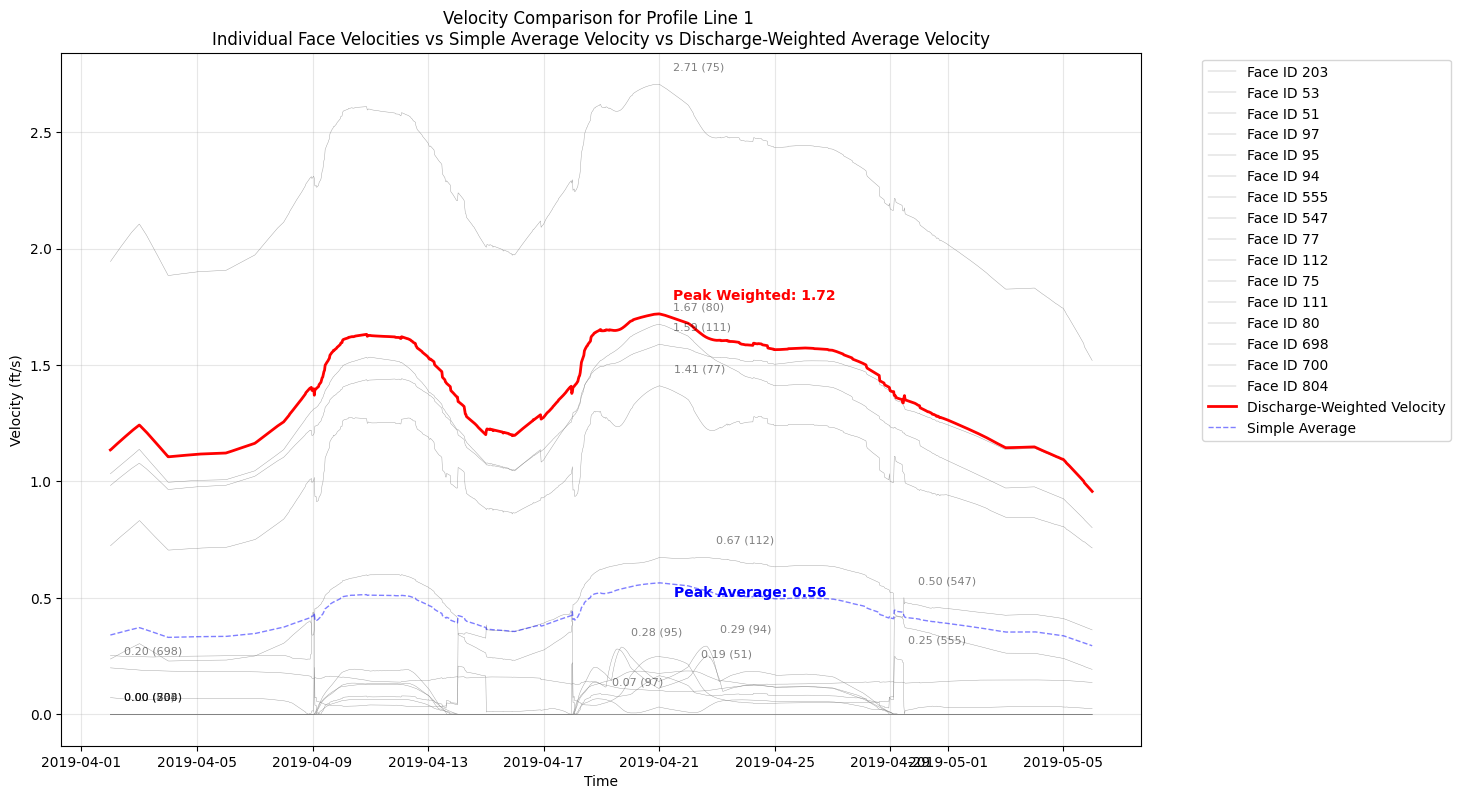


Velocity Comparison for Profile Line 1 
Individual Face Velocities vs Simple Average Velocity vs Discharge-Weighted Average Velocity
Number of faces: 16

Discharge-Weighted Velocity Statistics:
Mean: 1.38 ft/s
Max: 1.72 ft/s
Min: 0.96 ft/s

Simple Average Velocity Statistics:
Mean: 0.43 ft/s
Max: 0.56 ft/s
Min: 0.29 ft/s

Generating comparison plot for profile: Profile Line 2
Calculating weighted velocity...
Input DataFrame columns: ['time', 'face_id', 'face_velocity', 'face_flow', 'profile_name', 'face_order']
Calculated velocities:
                 time  weighted_velocity
0 2019-04-02 00:00:00           0.830894
1 2019-04-02 00:30:00           0.831717
2 2019-04-02 01:00:00           0.833358
3 2019-04-02 01:30:00           0.834911
4 2019-04-02 02:00:00           0.836487


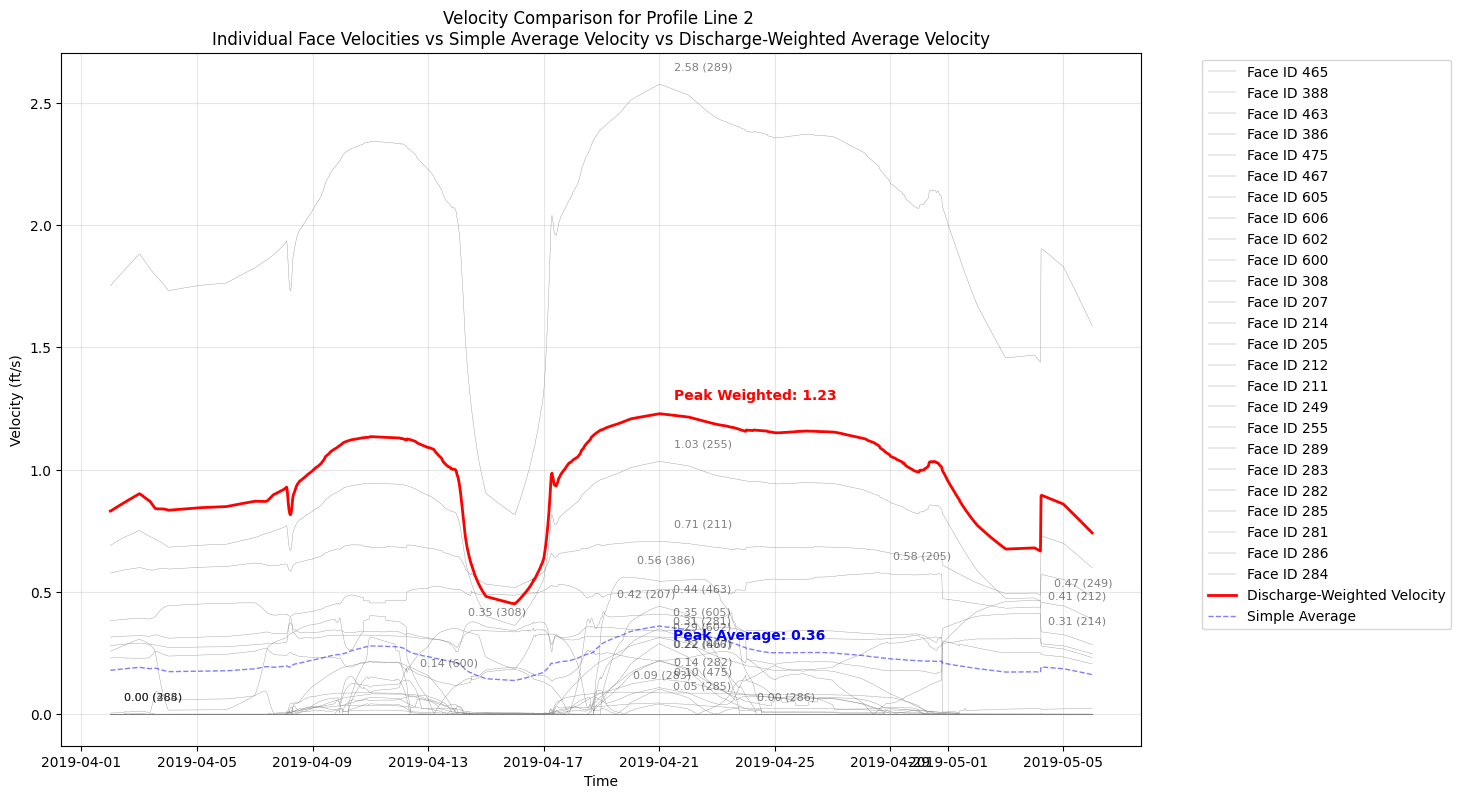


Velocity Comparison for Profile Line 2 
Individual Face Velocities vs Simple Average Velocity vs Discharge-Weighted Average Velocity
Number of faces: 25

Discharge-Weighted Velocity Statistics:
Mean: 0.97 ft/s
Max: 1.23 ft/s
Min: 0.45 ft/s

Simple Average Velocity Statistics:
Mean: 0.23 ft/s
Max: 0.36 ft/s
Min: 0.14 ft/s

Generating comparison plot for profile: Profile Line 3
Calculating weighted velocity...
Input DataFrame columns: ['time', 'face_id', 'face_velocity', 'face_flow', 'profile_name', 'face_order']
Calculated velocities:
                 time  weighted_velocity
0 2019-04-02 00:00:00           0.201104
1 2019-04-02 00:30:00           0.201087
2 2019-04-02 01:00:00           0.201383
3 2019-04-02 01:30:00           0.201665
4 2019-04-02 02:00:00           0.201957


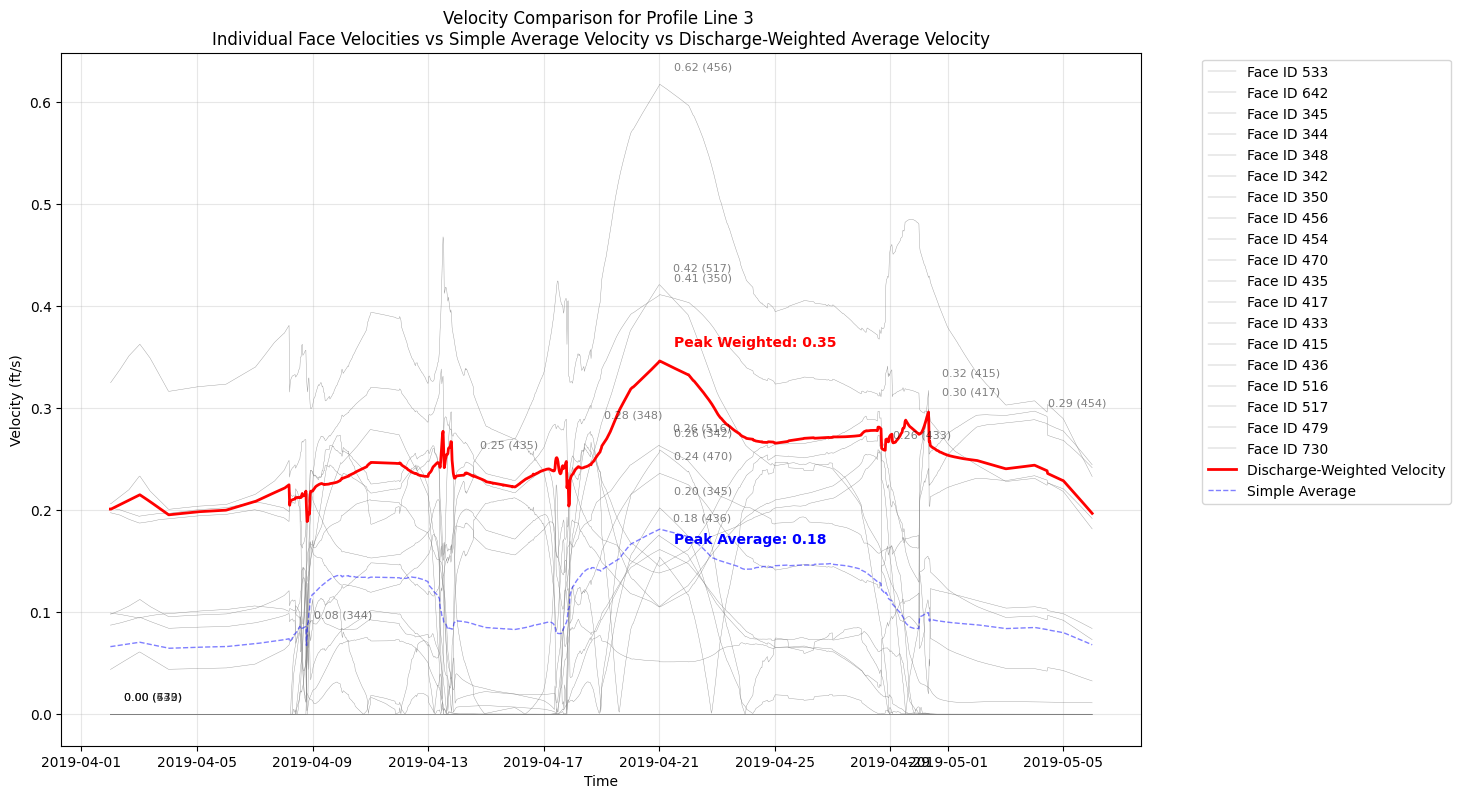


Velocity Comparison for Profile Line 3 
Individual Face Velocities vs Simple Average Velocity vs Discharge-Weighted Average Velocity
Number of faces: 19

Discharge-Weighted Velocity Statistics:
Mean: 0.25 ft/s
Max: 0.35 ft/s
Min: 0.19 ft/s

Simple Average Velocity Statistics:
Mean: 0.11 ft/s
Max: 0.18 ft/s
Min: 0.06 ft/s


In [45]:
# Create plots comparing discharge-weighted velocity and simple average for each profile line
for profile_name, profile_df in profile_time_series.items():
    
    print(f"\nGenerating comparison plot for profile: {profile_name}")
    
    # Calculate discharge-weighted velocity
    weighted_velocities = calculate_discharge_weighted_velocity(profile_df)
    weighted_velocities['time'] = pd.to_datetime(weighted_velocities['time'])
    
    # Calculate simple average velocity for each timestep
    simple_averages = profile_df.groupby('time')['face_velocity'].mean().reset_index()
    simple_averages['time'] = pd.to_datetime(simple_averages['time'])
    
    # Create figure for comparison plot
    plt.figure(figsize=(16, 9))
    
    # Plot individual face velocities with thin lines
    for face_id in profile_df['face_id'].unique():
        face_data = profile_df[profile_df['face_id'] == face_id]
        plt.plot(face_data['time'], 
                face_data['face_velocity'], 
                alpha=0.8,  # More transparent
                linewidth=0.3,  # Thinner line
                color='gray',  # Consistent color
                label=f'Face ID {face_id}')
        
        # Find and annotate peak value for each face
        peak_idx = face_data['face_velocity'].idxmax()
        peak_time = face_data.loc[peak_idx, 'time']
        peak_vel = face_data.loc[peak_idx, 'face_velocity']
        plt.annotate(f'{peak_vel:.2f} ({face_id})',
                    xy=(peak_time, peak_vel),
                    xytext=(10, 10),
                    textcoords='offset points',
                    fontsize=8,
                    alpha=0.5)
    
    # Plot discharge-weighted velocity
    plt.plot(weighted_velocities['time'], 
            weighted_velocities['weighted_velocity'], 
            color='red', 
            alpha=1.0, 
            linewidth=2,
            label='Discharge-Weighted Velocity')
    
    # Find and annotate peak weighted velocity
    peak_idx = weighted_velocities['weighted_velocity'].idxmax()
    peak_time = weighted_velocities.loc[peak_idx, 'time']
    peak_vel = weighted_velocities.loc[peak_idx, 'weighted_velocity']
    plt.annotate(f'Peak Weighted: {peak_vel:.2f}',
                xy=(peak_time, peak_vel),
                xytext=(10, 10),
                textcoords='offset points',
                color='red',
                fontweight='bold')
    
    # Plot simple average
    plt.plot(simple_averages['time'], 
            simple_averages['face_velocity'], 
            color='blue', 
            alpha=0.5, 
            linewidth=1,
            linestyle='--',
            label='Simple Average')
    
    # Find and annotate peak simple average
    peak_idx = simple_averages['face_velocity'].idxmax()
    peak_time = simple_averages.loc[peak_idx, 'time']
    peak_vel = simple_averages.loc[peak_idx, 'face_velocity']
    plt.annotate(f'Peak Average: {peak_vel:.2f}',
                xy=(peak_time, peak_vel),
                xytext=(10, -10),
                textcoords='offset points',
                color='blue',
                fontweight='bold')
    
    # Configure plot
    plt.title(f'Velocity Comparison for {profile_name} \nIndividual Face Velocities vs Simple Average Velocity vs Discharge-Weighted Average Velocity')
    plt.xlabel('Time')
    plt.ylabel('Velocity (ft/s)')
    plt.grid(True, alpha=0.3)
    
    # Add legend with better placement
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout to accommodate legend and stats
    plt.subplots_adjust(right=0.8)
    
    # Save plot to file
    plot_file = ras.project_folder / f"{profile_name}_velocity_comparison.png"
    plt.savefig(plot_file, bbox_inches='tight', dpi=300)
    plt.show()
    
    # Print detailed comparison
    print(f"\nVelocity Comparison for {profile_name} \nIndividual Face Velocities vs Simple Average Velocity vs Discharge-Weighted Average Velocity")
    print(f"Number of faces: {profile_df['face_id'].nunique()}")
    print("\nDischarge-Weighted Velocity Statistics:")
    print(f"Mean: {weighted_velocities['weighted_velocity'].mean():.2f} ft/s")
    print(f"Max: {weighted_velocities['weighted_velocity'].max():.2f} ft/s")
    print(f"Min: {weighted_velocities['weighted_velocity'].min():.2f} ft/s")
    print("\nSimple Average Velocity Statistics:")
    print(f"Mean: {simple_averages['face_velocity'].mean():.2f} ft/s")
    print(f"Max: {simple_averages['face_velocity'].max():.2f} ft/s")
    print(f"Min: {simple_averages['face_velocity'].min():.2f} ft/s")

## Important Notes on Face Velocity Interpretation

**Perpendicularity Requirement**:
The face normal velocity from HDF is only accurate when cell faces are perpendicular to flow.
The `HdfMesh.get_faces_along_profile_line()` function includes an `angle_threshold` parameter
to filter faces that deviate too far from perpendicular (default: 60 degrees from perpendicular).

**Profile Line Orientation**:
- Draw profile lines across (perpendicular to) the expected flow direction
- The library function will select faces that are perpendicular to YOUR profile line
- This means selected faces will be roughly parallel to flow

**Discharge-Weighted vs Simple Average**:
- Simple average: treats all faces equally (can be misleading)
- Discharge-weighted: properly represents bulk flow behavior
- See `calculate_discharge_weighted_velocity()` in this notebook

**For More Robust Analysis**:
- Consider face area variations
- Validate against known rating curves or gauge data
- Use multiple profile lines to assess spatial variability